# Column generation approach

## Pre-requisites

In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import cg, config, dataset, layers, pack, superitems, utils, warm_start

In [2]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Dataset

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

In [5]:
ordered_products = 100
order = product_dataset.get_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,121958,193,221,371,2,15824263
1,671155,236,142,437,58,14644744
2,131932,228,139,254,26,8049768
3,365838,267,131,322,11,11262594
4,259178,253,191,580,68,28027340


<IPython.core.display.Javascript object>

In [6]:
order = pd.concat([order.sample(4)] * 5).reset_index(drop=True)
order.head()

,id,width,depth,height,weight,volume
0,191335,245,168,317,2,13047720
1,328947,177,174,226,9,6960348
2,555839,350,287,441,2,44298450
3,256840,187,144,281,12,7566768
4,191335,245,168,317,2,13047720


<IPython.core.display.Javascript object>

In [6]:
order = order.sample(15).reset_index(drop=True)
order["height"] = 400
order.head()

,id,width,depth,height,weight,volume
0,191335,245,168,400,2,13047720
1,328947,177,174,400,9,6960348
2,555839,350,287,400,2,44298450
3,256840,187,144,400,12,7566768
4,486232,218,54,400,2,3143124


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [15]:
utils.get_l0_lb(order, config.PALLET_DIMS)

1.0

<IPython.core.display.Javascript object>

In [16]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0.0, 0.0, 0.0, 0.0)

<IPython.core.display.Javascript object>

In [40]:
utils.get_l2_lb(order, config.PALLET_DIMS)

  2%|▏         | 4892/240000 [00:28<22:42, 172.59it/s]


KeyboardInterrupt: 

## Superitems

In [7]:
superitems_pool = superitems.SuperitemPool(
    order=order, pallet_dims=config.PALLET_DIMS, max_vstacked=4
)
superitems_pool.to_dataframe()

Generating horizontal 2-items superitems: 0it [00:00, ?it/s]
Generating horizontal 4-items superitems: 0it [00:00, ?it/s]
Generating vertical superitems: 100%|██████████| 13/13 [00:00<00:00, 58883.32it/s]


,width,depth,height,ids,type
0,245,168,400,[0],SingleItemSuperitem
1,177,174,400,[1],SingleItemSuperitem
2,350,287,400,[2],SingleItemSuperitem
3,187,144,400,[3],SingleItemSuperitem
4,218,54,400,[4],SingleItemSuperitem
5,302,121,400,[5],SingleItemSuperitem
6,232,494,400,[6],SingleItemSuperitem
7,287,157,400,[7],SingleItemSuperitem
8,236,142,400,[8],SingleItemSuperitem
9,286,158,400,[9],SingleItemSuperitem


<IPython.core.display.Javascript object>

In [24]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Vertical")]

,width,depth,height,ids,type
39,177,174,452,"[1, 5]",VerticalSuperitem
40,177,174,452,"[9, 13]",VerticalSuperitem
41,187,348,507,"[3, 9, 13]",VerticalSuperitem
42,187,144,562,"[7, 11]",VerticalSuperitem
43,187,144,562,"[15, 19]",VerticalSuperitem
44,187,288,562,"[3, 7, 11, 15]",VerticalSuperitem
45,245,168,634,"[0, 4]",VerticalSuperitem
46,245,168,634,"[8, 12]",VerticalSuperitem
47,350,336,758,"[2, 8, 12]",VerticalSuperitem
48,350,287,882,"[6, 10]",VerticalSuperitem


<IPython.core.display.Javascript object>

In [79]:
df = superitems_pool.to_dataframe()
df[df["type"].str.contains("Horizontal")]

,width,depth,height,ids,type


<IPython.core.display.Javascript object>

## Height groups

In [9]:
height_groups = warm_start.get_height_groups(superitems_pool, height_tol=5)
for group in height_groups:
    display(group.to_dataframe())

,width,depth,height,ids,type
0,245,168,400,[0],SingleItemSuperitem
1,177,174,400,[1],SingleItemSuperitem
2,350,287,400,[2],SingleItemSuperitem
3,187,144,400,[3],SingleItemSuperitem
4,218,54,400,[4],SingleItemSuperitem
5,302,121,400,[5],SingleItemSuperitem
6,232,494,400,[6],SingleItemSuperitem
7,287,157,400,[7],SingleItemSuperitem
8,236,142,400,[8],SingleItemSuperitem
9,286,158,400,[9],SingleItemSuperitem


,width,depth,height,ids,type
0,177,271,800,"[1, 13]",VerticalSuperitem
1,187,378,800,"[3, 14]",VerticalSuperitem
2,218,188,800,"[4, 11]",VerticalSuperitem
3,236,494,800,"[6, 8]",VerticalSuperitem
4,281,168,800,"[0, 10]",VerticalSuperitem
5,287,158,800,"[7, 9]",VerticalSuperitem
6,302,291,800,"[5, 12]",VerticalSuperitem


,width,depth,height,ids,type
0,218,188,1200,"[3, 4, 11]",VerticalSuperitem
1,245,494,1200,"[0, 6, 8]",VerticalSuperitem
2,350,291,1200,"[2, 5, 12]",VerticalSuperitem


,width,depth,height,ids,type
0,187,378,1600,"[1, 3, 13, 14]",VerticalSuperitem
1,236,494,1600,"[4, 6, 8, 11]",VerticalSuperitem
2,287,168,1600,"[0, 7, 9, 10]",VerticalSuperitem


<IPython.core.display.Javascript object>

## Maxrects

In [10]:
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS)
    final_layer_pool.extend(layer_pool)
final_layer_pool.to_dataframe()

,item,x,y,z,layer
0,0,0,0,0,0
1,1,0,0,0,1
2,2,0,0,0,2
3,3,0,0,0,3
4,4,0,0,0,4
...,...,...,...,...,...
95,7,0,494,1200,31
96,13,236,0,0,31
97,1,236,0,400,31
98,14,236,0,800,31


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


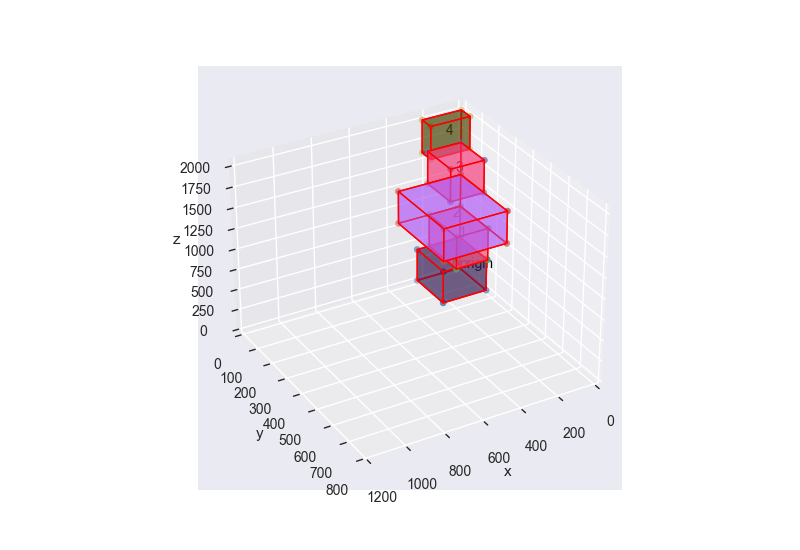

<IPython.core.display.Javascript object>


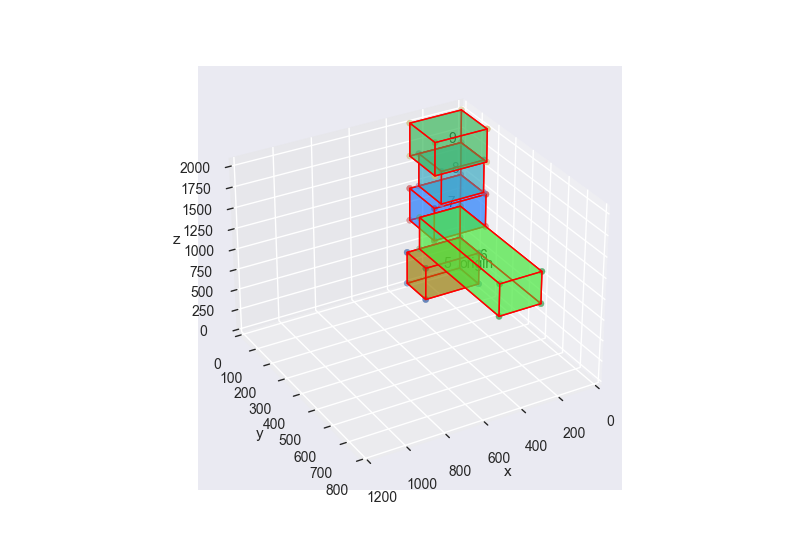

<IPython.core.display.Javascript object>


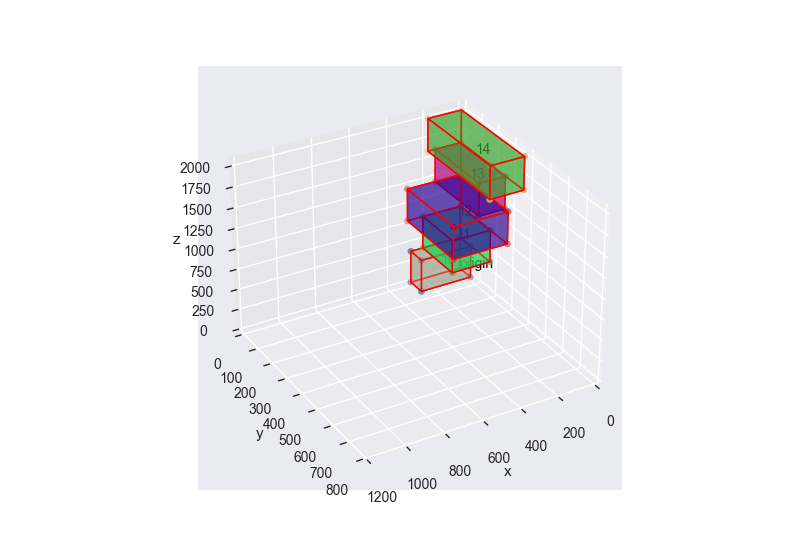

<IPython.core.display.Javascript object>


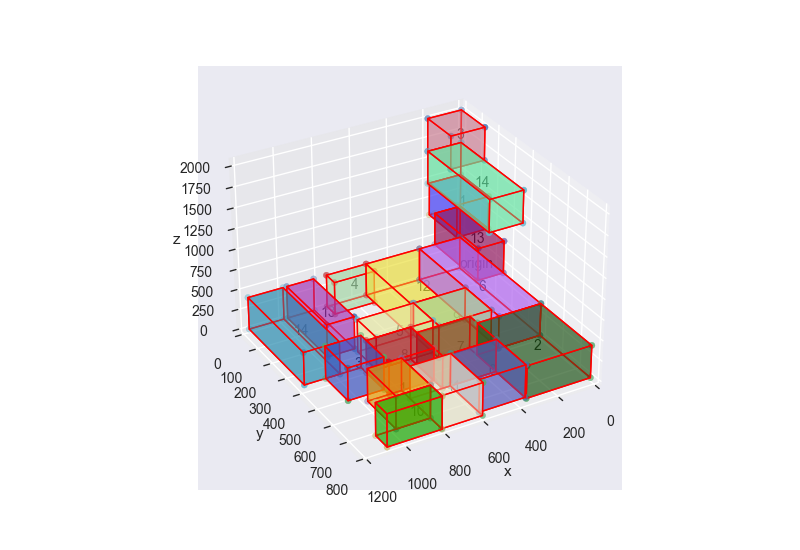

<IPython.core.display.Javascript object>


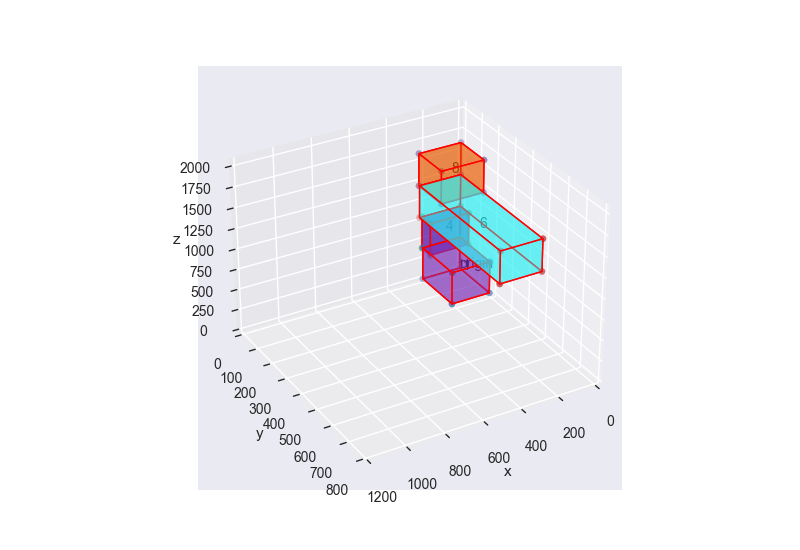

<IPython.core.display.Javascript object>


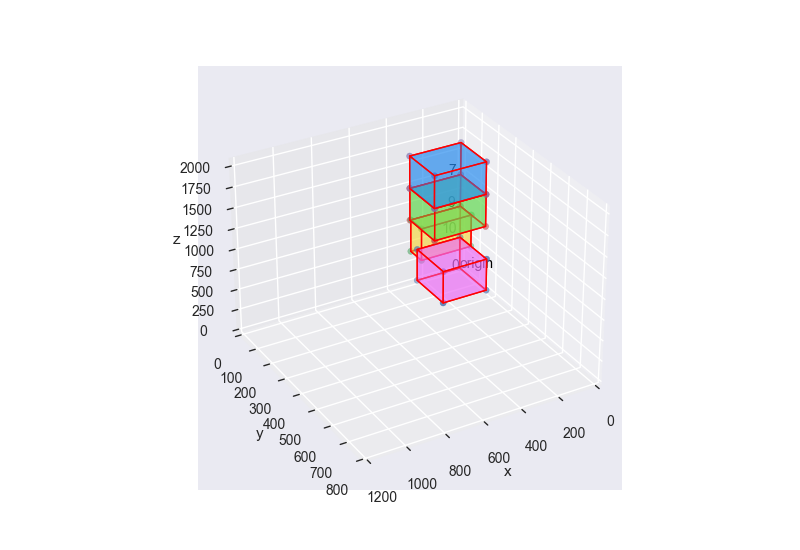

<IPython.core.display.Javascript object>


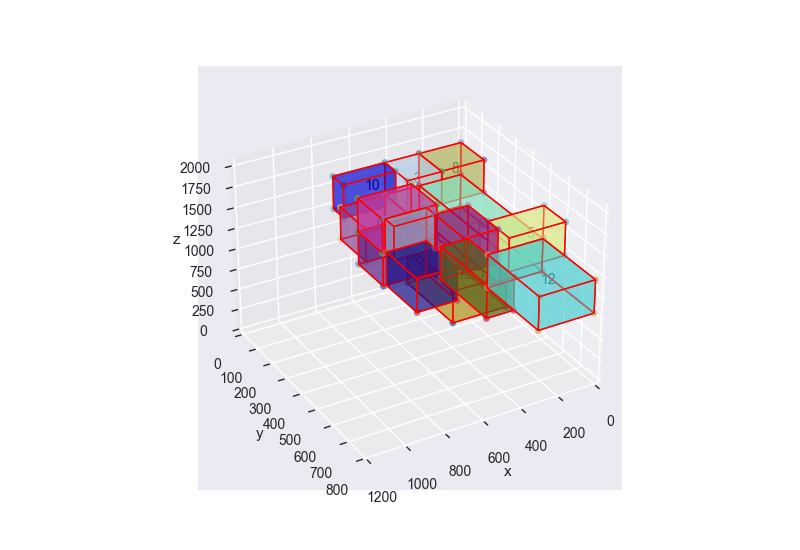

<IPython.core.display.Javascript object>


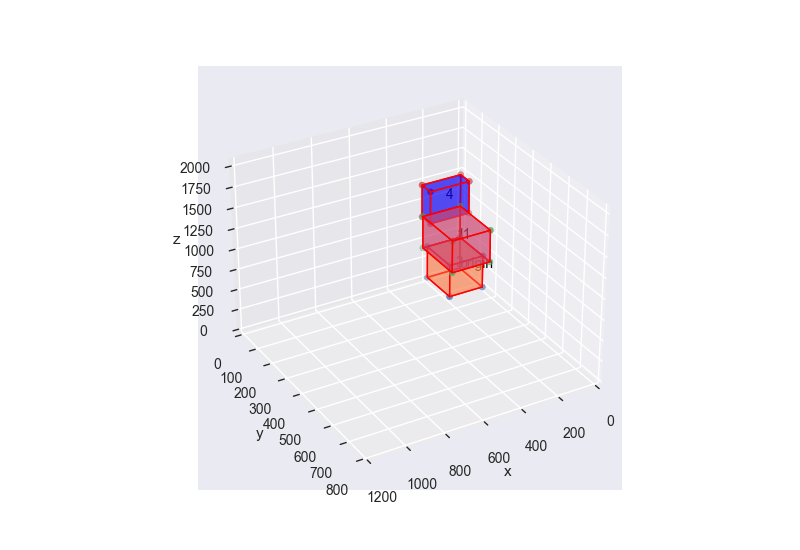

<IPython.core.display.Javascript object>


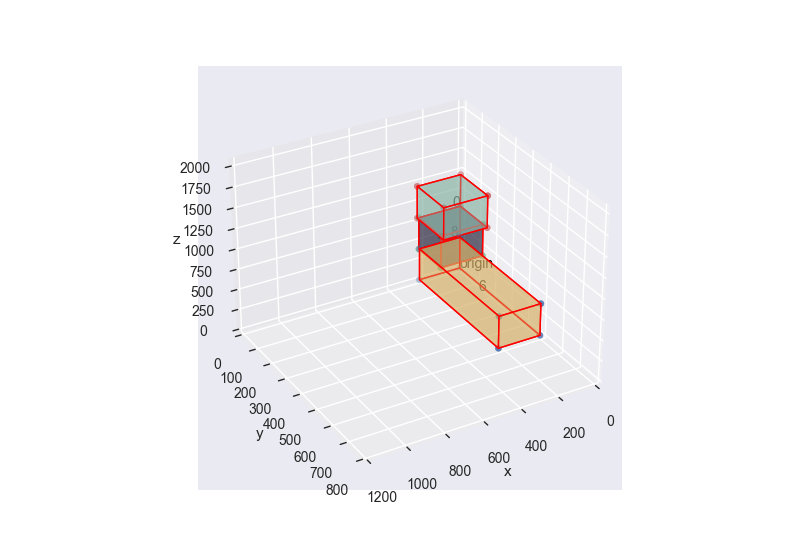

<IPython.core.display.Javascript object>


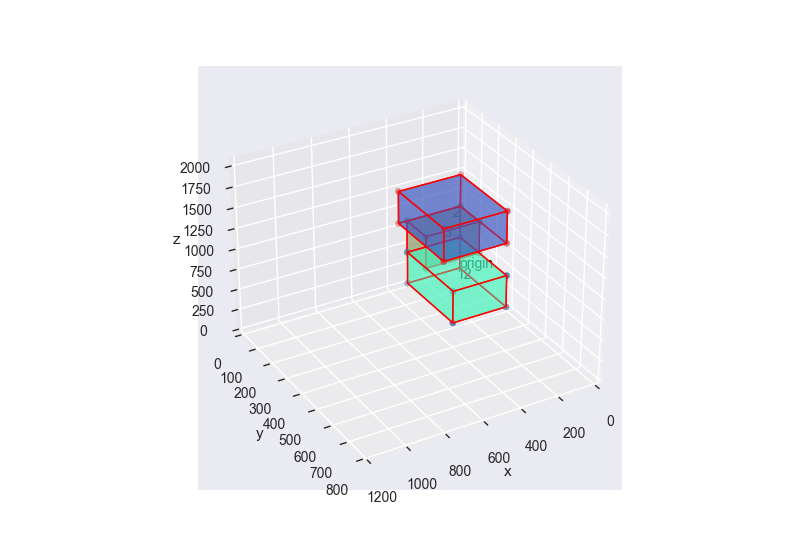

<IPython.core.display.Javascript object>


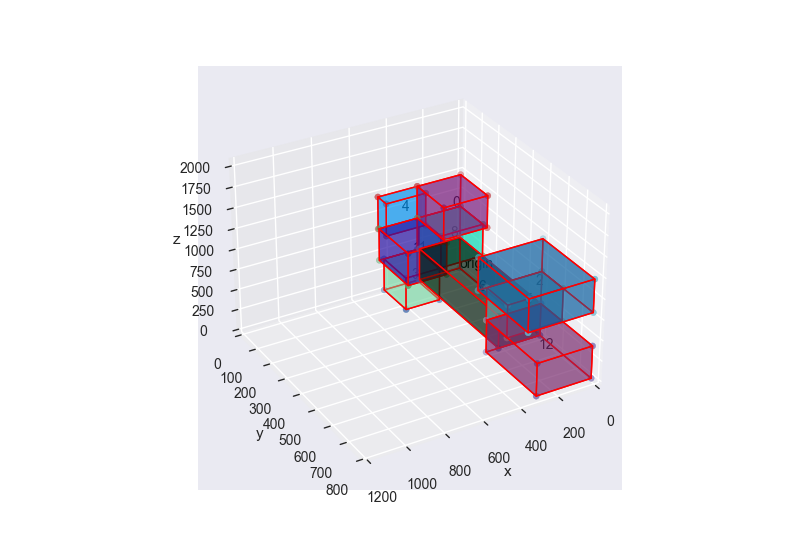

<IPython.core.display.Javascript object>


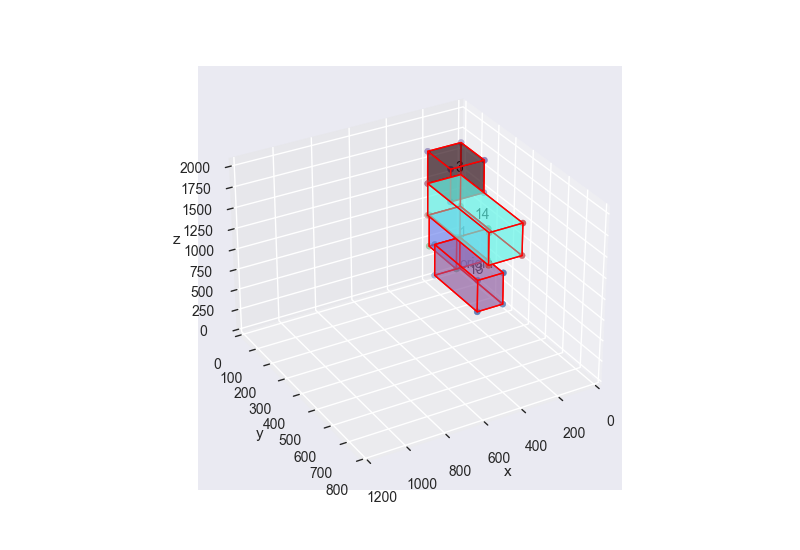

<IPython.core.display.Javascript object>


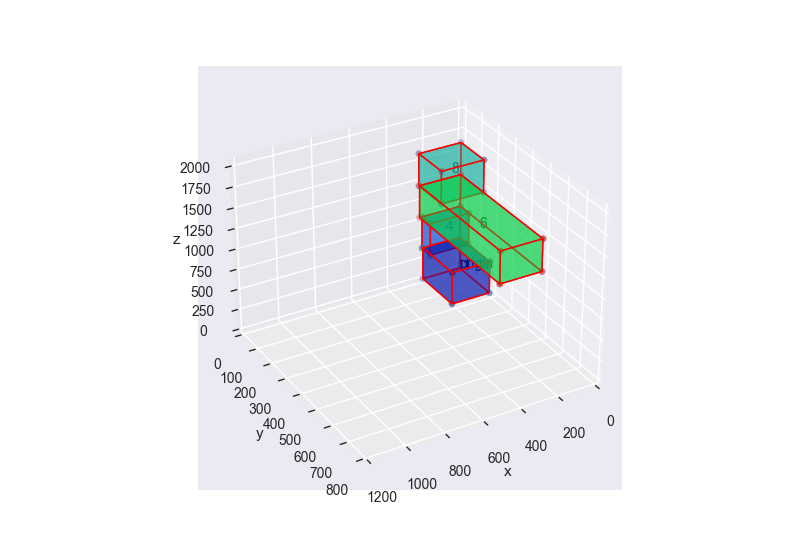

<IPython.core.display.Javascript object>


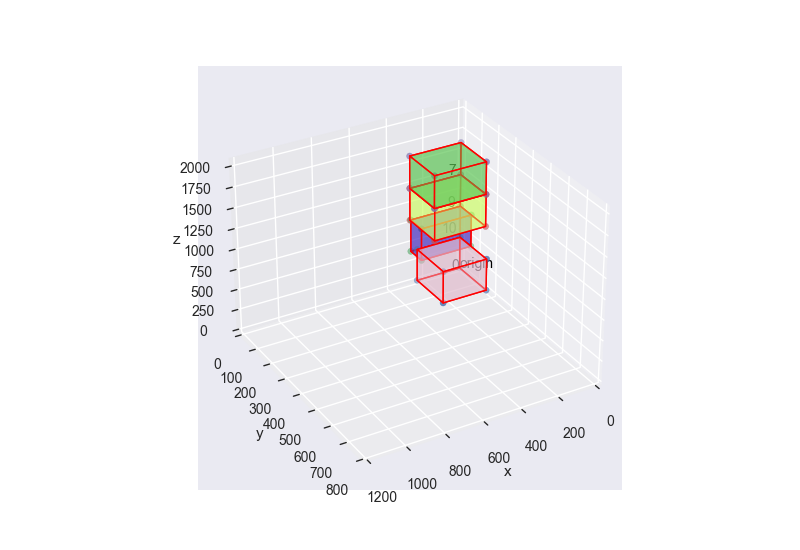

<IPython.core.display.Javascript object>


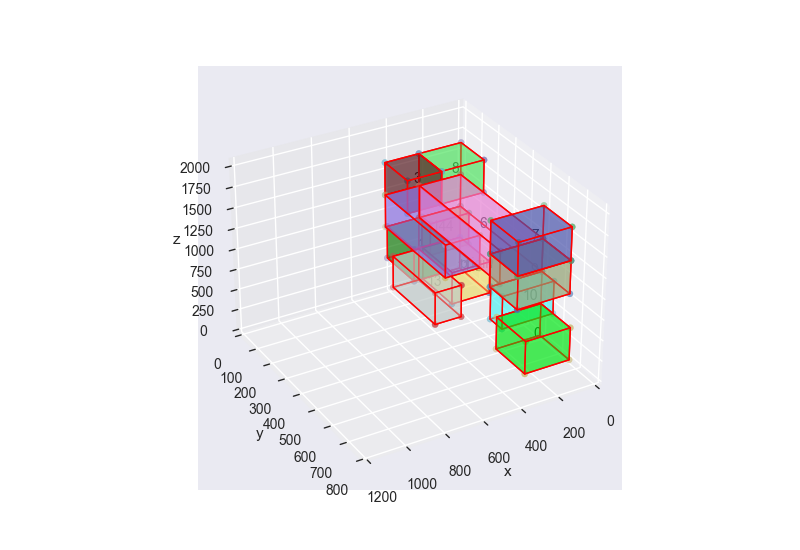

<IPython.core.display.Javascript object>

In [13]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.plot()

## Column generation

- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?

In [9]:
bins_lbs = []
final_layer_pool = layers.LayerPool(superitems.SuperitemPool())
for spool in height_groups:
    layer_pool = warm_start.maxrects(spool, config.PALLET_DIMS)
    layer_pool, bins_lb = cg.column_generation(
        layer_pool,
        config.PALLET_DIMS,
        max_iter=100,
        tlim=None,
    )
    final_layer_pool.extend(layer_pool)
    bins_lbs.append(bins_lb)
final_layer_pool.to_dataframe()

  0%|          | 0/100 [00:00<?, ?it/s]

Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 400.  -0.  -0.  -0.
  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [ -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0.  -0. 800.  -0.  -0.]
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0. 1200.]
Alpha: [0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)
Solving RMP...
Duals: [  -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0. 1600.]
Alpha: [0.0, 0.0, 0.0, 1.0]
Solving SP (no placement)...
Reduced cost: 0.0
Reached convergence :)


,item,x,y,z,layer
0,0,0,0,0,0
1,1,0,0,0,1
2,2,0,0,0,2
3,3,0,0,0,3
4,4,0,0,0,4
...,...,...,...,...,...
95,7,0,494,1200,31
96,13,236,0,0,31
97,1,236,0,400,31
98,14,236,0,800,31


<IPython.core.display.Javascript object>

In [55]:
np.floor(np.mean(bins_lbs) / config.max_product_height)

0.0

In [10]:
bin_pool = pack.BinPool(final_layer_pool, config.PALLET_DIMS)
bin_pool.plot()

LayerPool(layers=[Layer(height=400, ids=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])])


{0: [Layer(height=400, ids=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])]}

<IPython.core.display.Javascript object>

Todo:
- Come gestire oggetti volanti?
    - Spaziatura spiegata nel paper?
- Suddividere gruppi in piu gruppi
    - Verificare se superitem con stessi item possono essere nello stesso layer (sia in CP che maxrects)
        - Solo fra superitem con > 1 item e superitem con = 1 item
    - Provare superitems orizzontali: stesso item duplicato stesso layer
    
1. maxrects replace_items
2. suddivisione gruppi
3. s-shaped